In [4]:
import sys
import os
import glob
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
caffe_home = '/home/nathan/caffe-segnet-crf'
sys.path.insert(0,caffe_home+'/python')
import caffe

In [3]:
imgdir = '/home/nathan/mzmo/data/nuclei/seg_nuclei_0.1/feature'
os.path.dirname(imgdir)

'/home/nathan/mzmo/data/nuclei/seg_nuclei_0.1'

In [4]:
import glob
'''
Create a text file containing matching contents of imgdir and labeldir:

img1.jpg label1.jpg
img2.jpg label2.jpg

etc.

'''
def makelists(imgdir, labeldir, imgext='jpg', labelext='png', full_path=True):
    imgsearch = os.path.join(imgdir, '*.{}'.format(imgext))
    labelsearch = os.path.join(labeldir, '*.{}'.format(labelext))
    imglist = sorted(glob.glob(imgsearch))
    labellist = sorted(glob.glob(labelsearch))
    
    list_write = os.path.join(os.path.dirname(imgdir), 'list.txt')
    
    # This is assuming equality in the lists. 
    # If there are discrepancies, there are problems.
    with open(list_write, 'w') as f:
        for img, label in zip(imglist, labellist):
            s = '{} {}\n'.format(img, label)
            f.write(s)
    
    return list_write

In [6]:
imgdir = '/home/nathan/mzmo/data/nuclei/seg_nuclei_0.1/feature'
labeldir = '/home/nathan/mzmo/data/nuclei/seg_nuclei_0.1/mask'

makelists(imgdir, labeldir)

In [8]:
import lmdb
import cv2
import numpy as np
from caffe.proto import caffe_pb2
'''
Create lmdb databases

'''
ncrops = 10

# Do everything as a pair in order to not store stochastic crop info
imgsrc = '/home/nathan/mzmo/data/nuclei/seg_nuclei_0.1/feature'
masksrc = '/home/nathan/mzmo/data/nuclei/seg_nuclei_0.1/mask'

# Get a list
imglist = sorted(glob.glob(os.path.join(imgsrc, '*.jpg')))
masklist = sorted(glob.glob(os.path.join(masksrc, '*.png')))
print 'found {} imgaes in {}'.format(len(imglist), imgsrc)
print 'found {} imgaes in {}'.format(len(masklist), masksrc)

# Infer mapsize
sampleimg = cv2.imread(imglist[0])
est_total = sampleimg.nbytes * len(imglist) * 20  # Multiply by 3 for safety
print 'initializing with {} bytes'.format(est_total)

# Default put db in the same place as source
img_db = '/home/nathan/mzmo/data/nuclei/seg_nuclei_0.1/feature_lmdb'
mask_db = '/home/nathan/mzmo/data/nuclei/seg_nuclei_0.1/mask_lmdb'

imgenv = lmdb.open(img_db, map_size=est_total)
maskenv = lmdb.open(mask_db, map_size=est_total)

img_txn = imgenv.begin(write=True)
mask_txn = maskenv.begin(write=True)
index=1

debug_folder = '/home/nathan/mzmo/data/nuclei/seg_nuclei_0.1/debug'

# with (imgenv.begin(write=True), maskenv.begin(write=True)) as (img_txn, mask_txn):
for k, (img_name, mask_name) in enumerate(zip(imglist, masklist)):
    mask = cv2.imread(mask_name, cv2.CV_LOAD_IMAGE_GRAYSCALE)
#     mask = mask>0

    img = cv2.imread(img_name)
    channels = img.shape[2]

#     print img.shape
    h,w = img.shape[:2]

    for j in range(ncrops):
        x = np.random.randint((h/2)-1)
        y = np.random.randint((w/2)-1)
        size = 128
        subimg = img[x:x+size, y:y+size, :]
        submask = mask[x:x+size, y:y+size]

        subimg = cv2.resize(subimg, dsize=(256, 256))
        submask = cv2.resize(submask, dsize=(256, 256))
        submask = submask > 0
        submask.dtype = np.uint8

        # What
        imgdatum = caffe.proto.caffe_pb2.Datum()
        imgdatum.channels = channels
        imgdatum.height = subimg.shape[0]
        imgdatum.width = subimg.shape[1]
        imgdatum.data = subimg.tostring()  # wwwhhhattt

        str_id = '{:07}'.format(index)
        img_txn.put(str_id.encode('ascii'), imgdatum.SerializeToString())

        maskdatum = caffe.proto.caffe_pb2.Datum()
        maskdatum.channels = 1
        maskdatum.height = submask.shape[0]
        maskdatum.width = submask.shape[1]
        maskdatum.data = submask.tostring()  # wwwhhhattt

#         str_id = '{:07}'.format(index)
        mask_txn.put(str_id.encode('ascii'), maskdatum.SerializeToString())

        if index % 500 == 0:
            print index
            cv2.imwrite(os.path.join(debug_folder, '{}.jpg'.format(str_id)), subimg)
            cv2.imwrite(os.path.join(debug_folder, '{}.png'.format(str_id)), submask*255)


        index+=1

img_txn.close()
mask_txn.close()
            
print 'Done'

found 698 imgaes in /home/nathan/mzmo/data/nuclei/seg_nuclei_0.1/feature
found 698 imgaes in /home/nathan/mzmo/data/nuclei/seg_nuclei_0.1/mask
initializing with 2744647680 bytes
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500


AttributeError: 'Transaction' object has no attribute 'close'

In [9]:
imgenv.close()
maskenv.close()

In [12]:
labellist = sorted(glob.glob(
    os.path.join('/home/nathan/mzmo/data/nuclei/seg_nuclei_0.1/mask', '*.png')
))

def doti(p):
    img = cv2.imread(p, cv2.CV_LOAD_IMAGE_GRAYSCALE)
    img = img>0
    img.dtype = np.uint8
    cv2.imwrite(p, img)
    
_ = [doti(p) for p in labellist]

Found 698 images


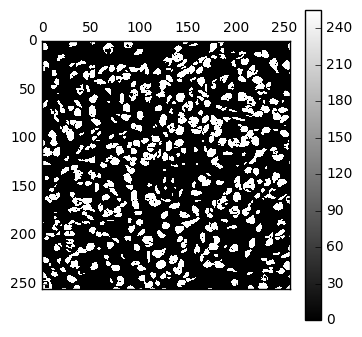

In [11]:
labellist = sorted(glob.glob(
    os.path.join('/home/nathan/mzmo/data/nuclei/seg_nuclei_0.1/mask', '*.png')
))
print 'Found {} images'.format(len(labellist))

# sample_label = np.random.sample(labellist)
sample_label = labellist[0]
label_img = cv2.imread(sample_label, cv2.CV_LOAD_IMAGE_GRAYSCALE)

plt.matshow(label_img, cmap='gray')
plt.colorbar()

Found 698 images
14 255


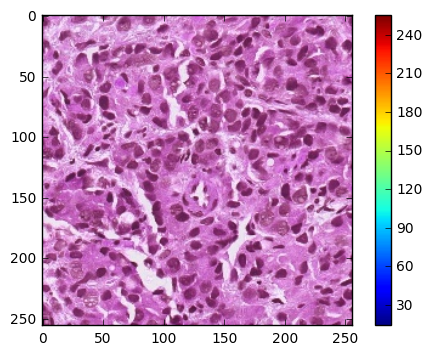

In [36]:
imlist = sorted(glob.glob(
    os.path.join('/home/nathan/mzmo/data/nuclei/seg_nuclei_0.1/feature', '*.jpg')
))
print 'Found {} images'.format(len(imlist))

# sample_label = np.random.sample(labellist)
sample_im = imlist[0]
im_img = cv2.imread(sample_im)

plt.imshow(im_img)
plt.colorbar()

print im_img.min(), im_img.max()